In [22]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.cnce import CondNceCrit
from src.nce.cd_cnce import CdCnceCrit
from src.nce.cd_mh import CdMHCrit

from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EXPERIMENT HELP FUNCTIONS

In [23]:
# Noise distribution parameters, CNCE
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_covariance_matrix(epsilon_factor, epsilon_base, num_dims):
    return torch.eye(num_dims) * (epsilon_factor * epsilon_base)**2


# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision):
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
    epsilon_base = get_cnce_epsilon_base(y)
    return get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))


def evaluate_cnce_loss(y, epsilon_factor, neg_sample_size, p_m):
    
    epsilon_base = get_cnce_epsilon_base(y)
    cov_noise = get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n, neg_sample_size)
    
    return criterion.crit(y, 0)


def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    loss = evaluate_cnce_loss(y, epsilon_factor, neg_sample_size, p_m)

    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        loss = evaluate_cnce_loss(y, epsilon_factor, neg_sample_size, p_m)

        k = k + 1
    
    return epsilon_factor


In [24]:
# Generation of true parameters, parameter initialisation

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5, z_min = 0.01):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    
    z = torch.rand(1) + z_min

    return mu, torch.log(precision), torch.log(z)


## EXPERIMENTS

In [30]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 5

# Training specs
batch_size = 32
num_epochs = 5

In [31]:
# An attempt to make things a bit nicer and more versatile

# Configurations to consider in experiments 

config_conditional = {
    "criterion": CondNceCrit,
    "label": "conditional",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
}

config_conditional_multi = {
    "criterion": CdCnceCrit,
    "label": "cd_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 1,
}

config_cd_mh = {
    "criterion": CdMHCrit,
    "label": "cd_mh",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 1,
}

configs = [config_conditional, # Detta är mer för någon typ av sanity check
           config_conditional_multi,
           config_cd_mh]

In [32]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(configs), reps))

for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        
            for k, config in enumerate(configs):
                
                # Make sure that these are "reinitialised"
                p_m, p_n, criterion = None, None, None
                
                if config["estimate_part_fn"]:
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init.clone(), log_part_fn=log_z_init.clone())
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init.clone())
                    
                p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                                        
                if config["mcmc_steps"] is not None:
                    criterion = config["criterion"](p_m, p_n, J, config["mcmc_steps"])
                else:
                    criterion = config["criterion"](p_m, p_n, J)
                
                save_dir = None
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)
                

np.save("res/final_param_error_ring_model_all", error_res)

Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished t

In [33]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

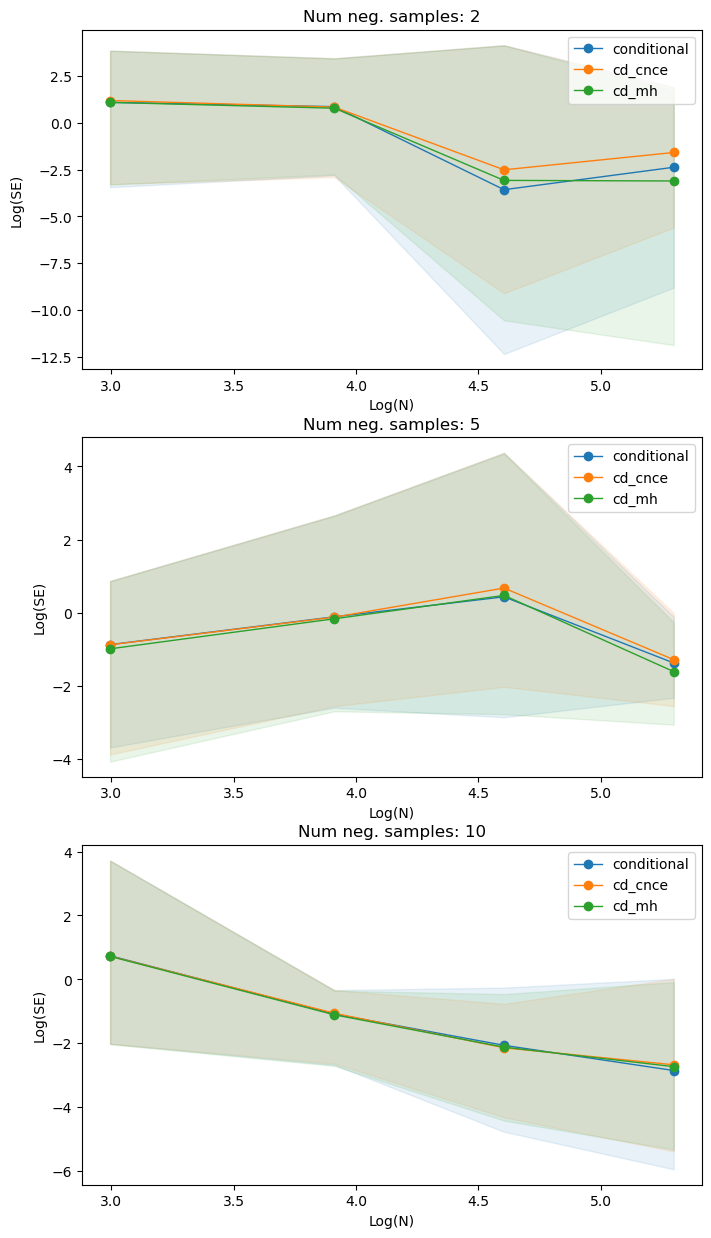

In [34]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['C0', 'C1', 'C2'] #, 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
assert len(colors) == len(configs), "Need one colour for each method"

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, config in enumerate(configs):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), config["label"], colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()